*Теоретический материал:* https://youtu.be/7vcy8RGYOIE?t=270

#Прогнозирование акций Лукойл

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=1169



In [ ]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('/content/drive/My Drive/Базы/акции лукойл/18_19.csv', sep=';')

In [ ]:
#Выводим пять первых строк
base_data.head()

,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722
3,03.01.2018,10:03:00,3354.5,3360.0,3354.5,3358.0,3034
4,03.01.2018,10:04:00,3358.0,3360.0,3351.5,3360.0,1427


In [ ]:
#Выцепялем numpy значения .values
#И выводим нулевой
txt = base_data.values[0]
print(txt)

['03.01.2018' '10:00:00' 3341.0 3356.0 3340.0 3355.0 6088]


In [ ]:
base_data16 = pd.read_csv('/content/drive/My Drive/Базы/акции лукойл/16_17.csv', sep=';')
base_data18 = pd.read_csv('/content/drive/My Drive/Базы/акции лукойл/18_19.csv', sep=';')
data16_17 = base_data16.iloc[:,2:]
data18_19 = base_data18.iloc[:,2:]

In [ ]:
data16_17.shape[0]

263925

In [ ]:
# Выводим параметры одного файла
d = data18_19
print(len(d)) # Сколько есть записей
print(len(d.iloc[0])) # Длина одной строки данных
print(d.iloc[0]) # Пример первой строки данных

217947
5
OPEN      3341.0
MAX       3356.0
MIN       3340.0
CLOSE     3355.0
VOLUME    6088.0
Name: 0, dtype: float64


In [ ]:
# Объединяем базы из двух файлов
data = data16_17.copy()                 # Создаем копию первой базы
data = pd.concat([data16_17,data18_19]) # Присоединяем к ней вторую базу
data = np.array(data)                   # Превращаем в numpy массив

In [ ]:
# Сравниваем размеры
print(len(data16_17)) # Выводим размер первой базы
print(len(data18_19)) # Выводим размер второй базы
print(len(data))      # Выводим размер суммарной базы

263925
217947
481872


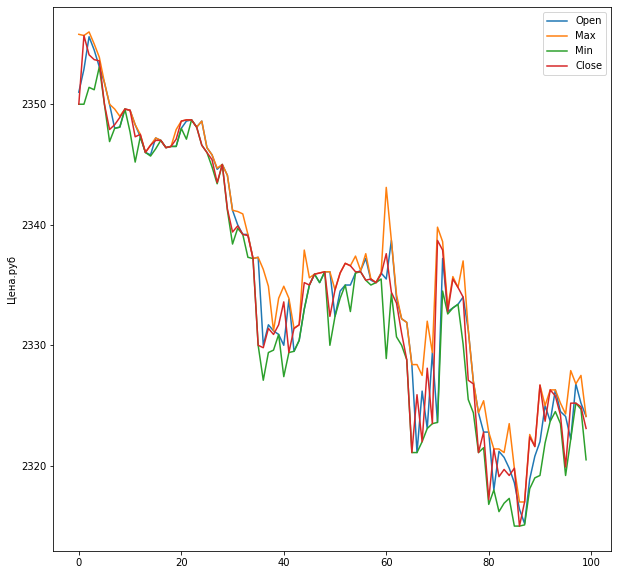

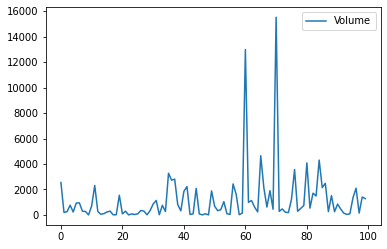

In [ ]:
plt.figure(figsize=(10,10))
#Отображаем исходные от точки start и длинной stop
start = 0            #С какой точки начинаем
#stop = data.shape[0] #Сколько точек отрисуем
stop = 100 #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+stop,i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+stop,4], label="Volume")
plt.legend()
plt.show()

**Функция загрузки данных**

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=1931



In [ ]:
#Формируем параметры загрузки данных

xLen = 300                      #Анализируем по 300 прошедшим точкам 
valLen = 30000                  #Используем 30.000 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,3],(-1,1)), np.reshape(data[trainLen+xLen+2:,3],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, stride=1, sampling_rate=1, #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=20)

In [ ]:
yTrain[0]

array([0.07810564])

In [ ]:
xTrain[0]

array([0.07839171, 0.07822035, 0.07839814, 0.07810564, 0.00059283])

In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 300, 5) (20, 1)


## Полносвязная сеть

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=3224



Epoch 1/2
22579/22579 [==============================] - 60s 3ms/step - loss: 0.0032 - val_loss: 4.5198e-04
Epoch 2/2
22579/22579 [==============================] - 59s 3ms/step - loss: 2.2024e-04 - val_loss: 1.3383e-04


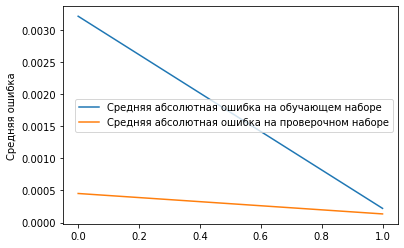

In [ ]:
#Создаём нейронку
modelD = Sequential()
modelD.add(Dense(150,input_shape = (xLen,5), activation="linear" )) # 5 - количество каналов
modelD.add(Flatten())
modelD.add(Dense(1, activation="linear"))

#Компилируем
modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

#Запускаем обучение
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=2, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Визуализация результатов

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=3705

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=300, sampling_rate=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 160, 0, predVal, yValUnscaled)


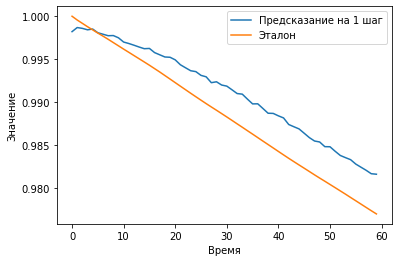

In [ ]:
#Отображаем корреляцию
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0], 60, predVal, yValUnscaled)

## Одномерная свёртка

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=6029



Epoch 1/20
22579/22579 [==============================] - 65s 3ms/step - loss: 0.0376 - val_loss: 6.4002e-05
Epoch 2/20
22579/22579 [==============================] - 64s 3ms/step - loss: 0.0013 - val_loss: 0.0321
Epoch 3/20
22579/22579 [==============================] - 64s 3ms/step - loss: 0.0012 - val_loss: 8.7049e-06
Epoch 4/20
22579/22579 [==============================] - 64s 3ms/step - loss: 3.8291e-04 - val_loss: 1.4321e-05
Epoch 5/20
22579/22579 [==============================] - 65s 3ms/step - loss: 2.1388e-04 - val_loss: 2.7368e-05
Epoch 6/20
22579/22579 [==============================] - 64s 3ms/step - loss: 2.4004e-04 - val_loss: 5.2866e-06
Epoch 7/20
22579/22579 [==============================] - 65s 3ms/step - loss: 5.3630e-05 - val_loss: 1.5196e-05
Epoch 8/20
22579/22579 [==============================] - 64s 3ms/step - loss: 3.3163e-05 - val_loss: 1.8977e-05
Epoch 9/20
22579/22579 [==============================] - 64s 3ms/step - loss: 2.5332e-05 - val_loss: 8.1955e-06

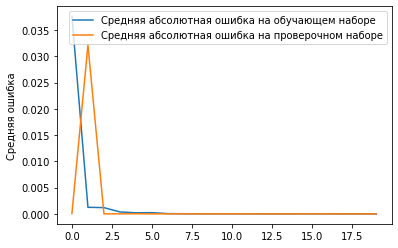

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(200, 5, input_shape = (xLen,5), activation="linear"))
#modelC.add(Flatten())
modelC.add(GlobalMaxPooling1D())

modelC.add(Dense(100, activation="linear"))
modelC.add(Dense(1, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit_generator(trainDataGen,
                    epochs=20, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()



In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

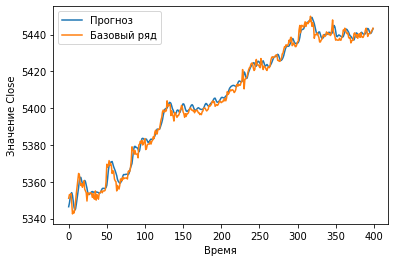

In [ ]:
#Отображаем графики
showPredict(10000, 400, 0, predVal, yValUnscaled)

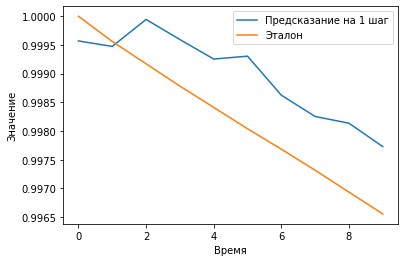

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## LSTM

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=6491

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
22579/22579 [==============================] - 371s 16ms/step - loss: 0.0157 - val_loss: 2.0684e-05
Epoch 2/10
22579/22579 [==============================] - 373s 17ms/step - loss: 3.8529e-05 - val_loss: 3.3516e-06
Epoch 3/10
22579/22579 [==============================] - 381s 17ms/step - loss: 7.1197e-06 - val_loss: 8.9598e-06
Epoch 4/10
22579/22579 [==============================] - 380s 17ms/step - loss: 2.3636e-06 - val_loss: 3.1176e-06
Epoch 5/10
22579/22579 [==============================] - 370s 16ms/step - loss: 2.1214e-06 - val_loss: 2.8961e-06
Epoch 6/10
22579/22579 [==============================] - 383s 17ms/step - loss: 1.9670e-06 - val_loss: 2.7049e-06
Epoch 7/10
22579/22579 [==============================] - 369s 16ms/step - loss: 1.8346e-06 - val_loss: 1.7682e-06
Epoch 8/10
22579/22579 [==============================] - 385s 17ms/step - loss: 1.7365e-06 - val_loss: 2.1713e-06
Epoch 9/

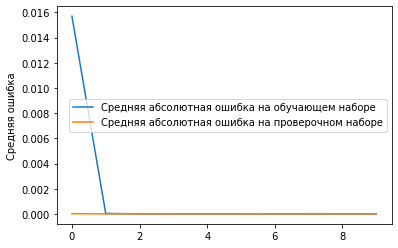

In [ ]:
import tensorflow
modelL = Sequential()
modelL.add(LSTM(5, input_shape = (xLen, 5)))
modelL.add(Dense(10, activation="linear"))
modelL.add(Dense(1, activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelL.fit_generator(trainDataGen, 
                    epochs=10, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelL
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

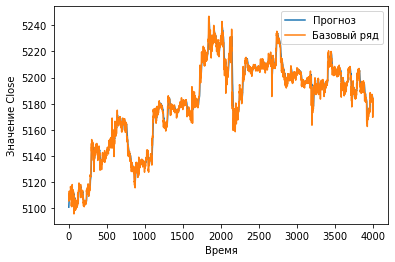

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

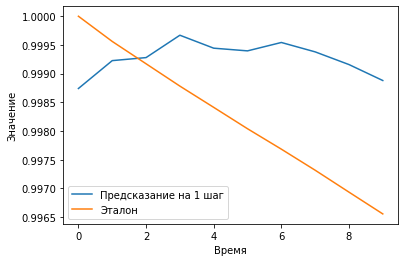

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## ModelX

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=6551



**Сложная сеть из LSTM и Conv1D слоёв на старте и Dense слоёв в конце**

In [ ]:
from tensorflow.keras.utils import plot_model

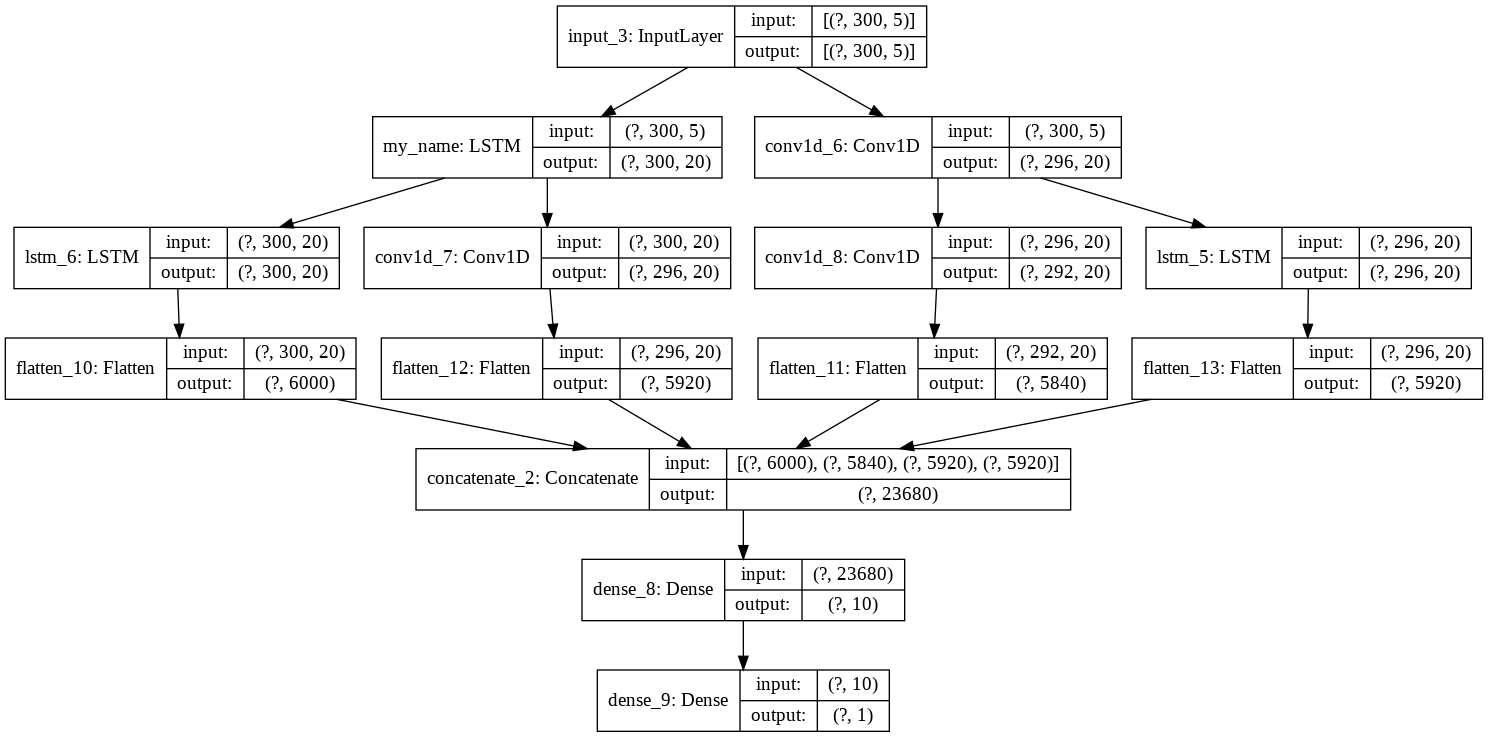

In [ ]:
dataInput = Input(shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]))

lstmWay = LSTM(20, return_sequences="True", name='my_name')(dataInput)
convWay = Conv1D(20, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(20, 5, activation="relu")(lstmWay)
convLstmWay = LSTM(20, return_sequences="True")(convWay)

lstmWay = LSTM(20, return_sequences="True")(lstmWay)
convWay = Conv1D(20, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

plot_model(modelX, show_shapes=True, show_layer_names=True)

Epoch 1/6
22579/22579 [==============================] - 985s 44ms/step - loss: 9.7152e-04 - val_loss: 4.5019e-05
Epoch 2/6
22579/22579 [==============================] - 974s 43ms/step - loss: 7.2238e-05 - val_loss: 4.5330e-05
Epoch 3/6
22579/22579 [==============================] - 965s 43ms/step - loss: 4.1237e-05 - val_loss: 1.5301e-05
Epoch 4/6
22579/22579 [==============================] - 962s 43ms/step - loss: 2.9914e-05 - val_loss: 1.3877e-04
Epoch 5/6
22579/22579 [==============================] - 960s 43ms/step - loss: 2.3818e-05 - val_loss: 5.7628e-06
Epoch 6/6
22579/22579 [==============================] - 963s 43ms/step - loss: 2.0044e-05 - val_loss: 5.8348e-06


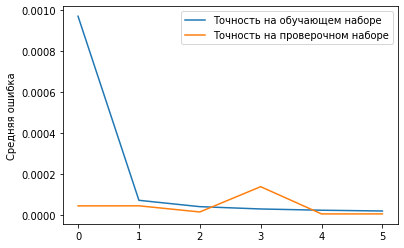

In [ ]:
dataInput = Input(shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]))

lstmWay = LSTM(20, return_sequences="True")(dataInput)
convWay = Conv1D(20, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(20, 5, activation="relu")(lstmWay)
convLstmWay = LSTM(20, return_sequences="True")(convWay)

lstmWay = LSTM(20, return_sequences="True")(lstmWay)
convWay = Conv1D(20, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

modelX.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelX.fit_generator(trainDataGen, 
                    epochs=6, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

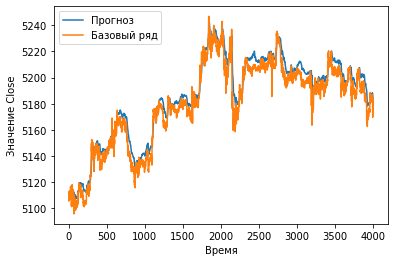

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

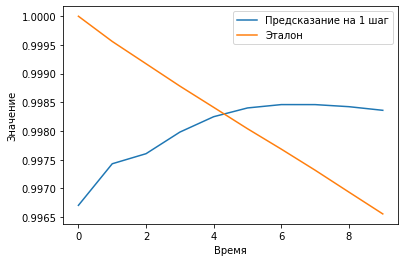

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

# Прогнозирование цены бензина

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=7217



In [ ]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Считываем данные с помощью pandas
#Для чтения tsv файла ставим sep='\t'
base_data = pd.read_csv('/content/drive/My Drive/Базы/petrol_price_2004-2019.tsv', sep='\t')

In [ ]:
base_data.head()

,Unnamed: 0,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
0,0,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ETANOL HIDRATADO,127,R$/l,1.288,0.016,1.19,1.350,0.463,0.012,0.825,0.11,0.4201,0.9666,0.133,5,2004
1,1,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ETANOL HIDRATADO,387,R$/l,1.162,0.114,0.89,1.449,0.399,0.098,0.763,0.088,0.5013,1.05,0.115,5,2004
2,2,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ETANOL HIDRATADO,192,R$/l,1.389,0.097,1.18,1.760,0.419,0.070,0.97,0.095,0.5614,1.161,0.098,5,2004
3,3,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ETANOL HIDRATADO,162,R$/l,1.262,0.070,1.09,1.509,0.432,0.055,0.83,0.119,0.5991,1.22242,0.143,5,2004
4,4,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ETANOL HIDRATADO,103,R$/l,1.181,0.078,1.05,1.400,0.24,0.066,0.941,0.077,0.7441,1.0317,0.082,5,2004


In [ ]:
print(base_data.iloc[:,9:12].head(20))

    DESVIO PADRÃO REVENDA  PREÇO MÍNIMO REVENDA  PREÇO MÁXIMO REVENDA
0                   0.016                 1.190                 1.350
1                   0.114                 0.890                 1.449
2                   0.097                 1.180                 1.760
3                   0.070                 1.090                 1.509
4                   0.078                 1.050                 1.400
5                   0.132                 0.999                 2.050
6                   0.218                 1.030                 1.950
7                   0.158                 1.350                 2.000
8                   0.130                 1.100                 1.699
9                   0.141                 0.989                 1.700
10                  0.134                 1.400                 1.780
11                  0.116                 1.090                 1.590
12                  0.109                 1.150                 1.750
13                  

In [ ]:
#Группируем данные по неделе старта
#В исходных данных по каждой неделе данные по нескольким регионам страны
data2 = base_data.groupby('DATA INICIAL').mean()

#Оставляем колонки с 3 по 7
#В них нужные для нас числовые данные
data = data2.values[:,2:-1]
print(data.shape)

(785, 6)


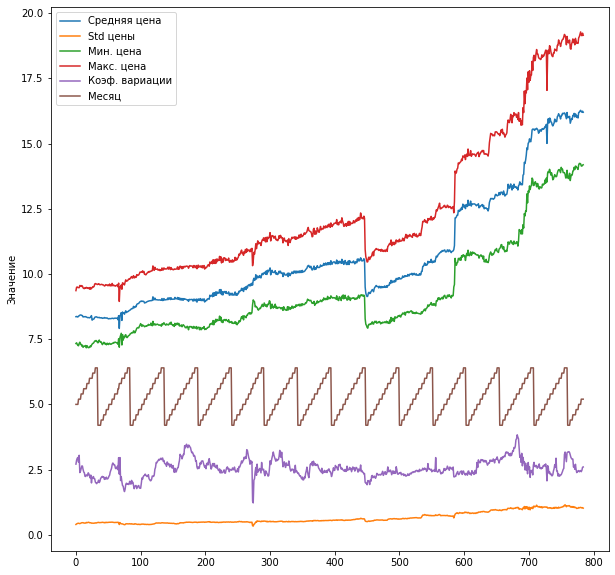

In [ ]:
#Отображаем исходные от точки start и длинной step
start = 0
step = 785

#Подбираем смещения, чтобы удобно расположить графики на экране
koef = [1, 1, 1, 1, 100, 0.2]
bias = [0, 0, 0, 0, -2, 4]

#Заполняем текстовые названия каналов данных
chanelNames = ['Средняя цена', 'Std цены', 'Мин. цена', 'Макс. цена', 'Коэф. вариации', 'Месяц']

plt.figure(figsize=(10,10))
#Рисуем все графики данных
for i in range(data.shape[1]):
  plt.plot(koef[i]*data[start:start+step,i] + bias[i], 
          label=chanelNames[i])
plt.ylabel('Значение')
plt.legend()
plt.show()

**Функция загрузки данных**

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=7448

In [ ]:
#Формируем параметры загрузки данных

xLen = 20    #Анализируем по 20 прошедшим точкам 
valLen = 100 #Используем 100 записей для проверки

trainLen = data.shape[0]-valLen # Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen], data[trainLen:]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Делаем reshape,т.к. у нас только один столбец по одному значению
yTrain,yTest = np.reshape(data[:trainLen,0],(-1,1)), np.reshape(data[trainLen:,0],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=20, sampling_rate=1,   #Для каждой точки (из промежутка длины xLen)
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=20, sampling_rate=1,
                               batch_size=20)


In [ ]:
print(trainDataGen[0][0].shape,
      trainDataGen[0][1].shape)

(20, 20, 6) (20, 1)


## Полносвязная сеть

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=7532


Epoch 1/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0857 - val_loss: 0.6745
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0250 - val_loss: 0.3368
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0155 - val_loss: 0.1721
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0765
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0033 - val_loss: 0.0451
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0317
Epoch 7/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0364
Epoch 8/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0019 - val_loss: 0.0215
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0019 - val_loss: 0.0218
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0018 - val_loss: 0.0225
Epoch 11/

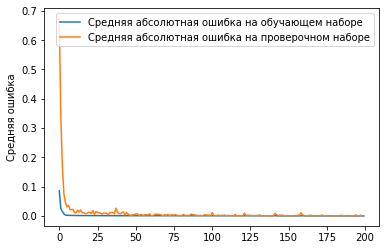

In [ ]:
modelD = Sequential()

modelD.add(Dense(100, input_shape = (xLen,6), activation="relu"))
modelD.add(Dense(100, activation="relu"))
modelD.add(Dense(100, activation="linear"))
modelD.add(Flatten())
modelD.add(Dense(yTrain.shape[1], activation="linear"))

modelD.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=200, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )


plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

## Визуализация результатов

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=7590

In [ ]:
# Функция рассчитываем результаты прогнозирования сети
# В аргументы принимает сеть (currModel) и проверочную выборку
# Выдаёт результаты предсказания predVal
# И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  # Предсказываем ответ сети по проверочной выборке
  # И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

# Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
# start - точка с которой начинаем отрисовку графика
# step - длина графика, которую отрисовываем
# channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
# Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

# Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [ ]:
# Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) # Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

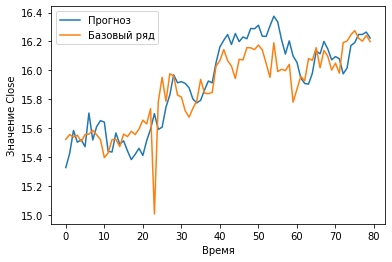

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

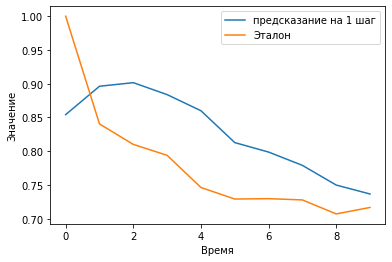

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## Одномерная свёртка

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=7623


Epoch 1/200
34/34 [==============================] - 0s 8ms/step - loss: 0.0658 - val_loss: 0.1194
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0491
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0151
Epoch 4/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0024
Epoch 5/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 6/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 7/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0083
Epoch 8/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0073
Epoch 9/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0127
Epoch 10/200
34/34 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 11/

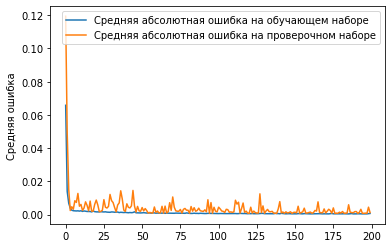

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(50, 10, padding="same", input_shape = (xLen, 6), activation="linear"))
modelC.add(Conv1D(100, 10, padding="same", activation="linear"))
modelC.add(Conv1D(100, 10, padding="same", activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(10, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelC.fit_generator(
                    trainDataGen, 
                    epochs=200, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

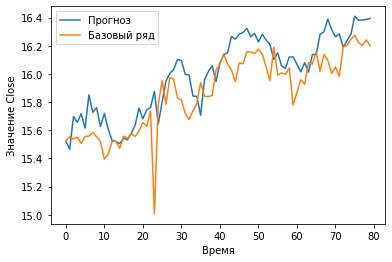

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

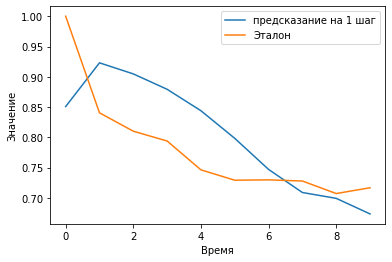

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## LSTM

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=7736

Epoch 1/100
34/34 [==============================] - 1s 38ms/step - loss: 0.1673 - val_loss: 1.4682
Epoch 2/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0917 - val_loss: 0.9716
Epoch 3/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0418 - val_loss: 0.5825
Epoch 4/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0228 - val_loss: 0.3769
Epoch 5/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0171 - val_loss: 0.2742
Epoch 6/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0144 - val_loss: 0.2463
Epoch 7/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0114 - val_loss: 0.1938
Epoch 8/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0104 - val_loss: 0.1436
Epoch 9/100
34/34 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.1219
Epoch 10/100
34/34 [==============================] - 0s 8ms/step - loss: 0.0061 - val_loss: 0.1053
Epoch 11

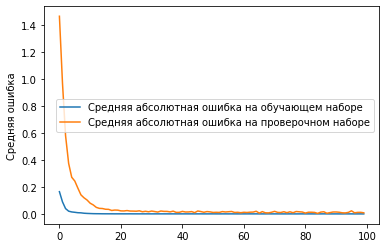

In [ ]:
modelL = Sequential()
modelL.add(LSTM(100, input_shape = (trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]), return_sequences="True"))
modelL.add(LSTM(100, return_sequences="True"))
modelL.add(LSTM(100, return_sequences="True"))
modelL.add(Flatten())
modelL.add(Dense(100, activation="linear"))
modelL.add(Dense(yTrain.shape[1], activation="linear"))

modelL.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelL.fit_generator(trainDataGen, 
                    epochs=100, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelL
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

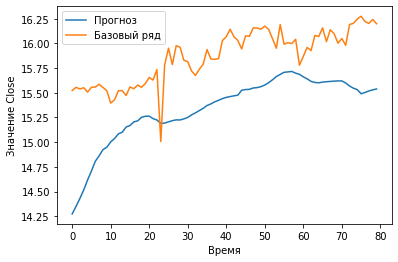

In [ ]:
#Отображаем графики
showPredict(0, 4000, 0, predVal, yValUnscaled)

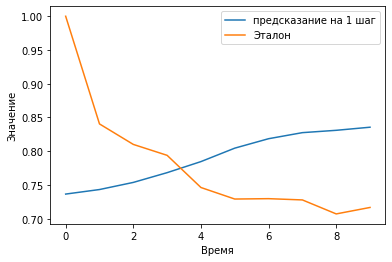

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## ModelX

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=7840


Сложная сеть из LSTM и Conv1D слоёв на старте и Dense слоёв в конце

Epoch 1/60
34/34 [==============================] - 1s 40ms/step - loss: 0.0323 - val_loss: 0.1205
Epoch 2/60
34/34 [==============================] - 0s 10ms/step - loss: 0.0102 - val_loss: 0.0656
Epoch 3/60
34/34 [==============================] - 0s 11ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 4/60
34/34 [==============================] - 0s 11ms/step - loss: 0.0028 - val_loss: 0.0061
Epoch 5/60
34/34 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0062
Epoch 6/60
34/34 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 7/60
34/34 [==============================] - 0s 10ms/step - loss: 0.0024 - val_loss: 0.0084
Epoch 8/60
34/34 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0046
Epoch 9/60
34/34 [==============================] - 0s 11ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 10/60
34/34 [==============================] - 0s 11ms/step - loss: 0.0023 - val_loss: 0.0061
Epoch 11/

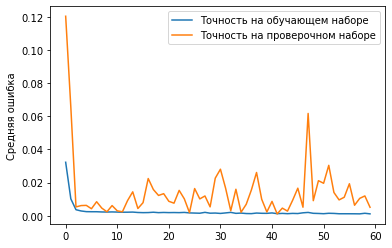

In [ ]:
dataInput = Input(shape=(trainDataGen[0][0].shape[1], trainDataGen[0][0].shape[2]))

lstmWay = LSTM(100, return_sequences="True")(dataInput)
convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmConvWay = Conv1D(100, 5, activation="relu")(lstmWay)
convLstmWay = LSTM(100, return_sequences="True")(convWay)

lstmWay = LSTM(100, return_sequences="True")(lstmWay)
convWay = Conv1D(100, 5, activation="relu")(convWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
lstmConvWay = Flatten()(lstmConvWay)
convLstmWay = Flatten()(convLstmWay)

finWay = concatenate([lstmWay, convWay, lstmConvWay, convLstmWay])
finWay = Dense(100, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX = Model(dataInput, finWay)

modelX.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelX.fit_generator(trainDataGen,  
                    epochs=60, 
                    verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

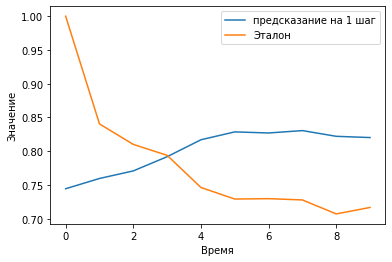

In [ ]:
#Отображаем корреляцию
showCorr([0], 10, predVal, yValUnscaled)

## Прогнозирование на несколько шагов вперёд

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=8009

In [ ]:
#Формируем параметры загрузки данных
xLen = 20                       #Анализируем по 20 прошедшим точкам 
valLen = 100                    #Используем 100 записей для проверки
stepsForward = 10
trainLen = data.shape[0]-valLen #Размер тренировочной выборки

#Делим данные на тренировочную и тестовую выборки 
xTrain,xTest = data[:trainLen-stepsForward], data[trainLen+xLen+2:-stepsForward+1]

#Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

#Для подготовки yTrain на 10 шагов вперед необходимо создать дополнительный датасет
yTrain = np.array([data[:trainLen,0][i:i+stepsForward] for i in range(trainLen-stepsForward)])
yTest = np.array([data[trainLen+xLen+2:,0][i:i+stepsForward] for i in range(valLen-xLen-stepsForward-1)])
yScaler = StandardScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(xTrain, yTrain,           #В качестве параметров наши выборки
                               length=xLen, sampling_rate=1, #Для каждой точки
                               batch_size=20)                #Размер batch, который будем скармливать модели

#Создаем аналогичный генератор для валидации при обучении
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(trainDataGen[10][0].shape,
      trainDataGen[10][1].shape)

(20, 20, 6) (20, 10)


In [ ]:
#Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest)) #Размер batch будет равен длине нашей выборки

xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

**Обучаем полносвязную сеть**

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=8155

Epoch 1/100
33/33 [==============================] - 0s 9ms/step - loss: 0.8384 - val_loss: 4.3170
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.1622 - val_loss: 0.1942
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0751 - val_loss: 0.0739
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0644 - val_loss: 0.0880
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0582 - val_loss: 0.1130
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0561 - val_loss: 0.0515
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0522 - val_loss: 0.0571
Epoch 8/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.0475
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0480 - val_loss: 0.0454
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0484 - val_loss: 0.0334
Epoch 11/

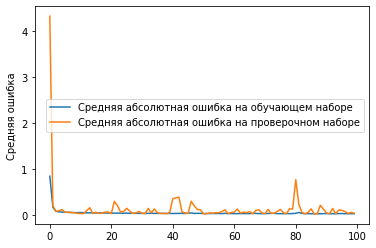

In [ ]:
modelD2 = Sequential()

modelD2.add(Dense(100, input_shape = (xLen,xTrain.shape[1]), activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Dense(100, activation="linear"))
modelD2.add(Flatten())
modelD2.add(Dense(yTrain.shape[1], activation="linear"))

modelD2.compile(loss="mse", optimizer=Adam(lr=1e-4))
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelD2.compile(loss="mse", optimizer=Adam(lr=1e-5))
history = modelD2.fit_generator(
                    trainDataGen, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/100
33/33 [==============================] - 0s 9ms/step - loss: 0.0228 - val_loss: 0.0371
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0225 - val_loss: 0.0333
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0223 - val_loss: 0.0273
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0361
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0223 - val_loss: 0.0369
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 0.0222 - val_loss: 0.0240
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0315
Epoch 8/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0222 - val_loss: 0.0335
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0326
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 0.0221 - val_loss: 0.0287
Epoch 11/

**Отображаем результаты**

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelD2
(predVal2, yValUnscaled2) = getPred(currModel, xVal[0], yVal[0], yScaler)

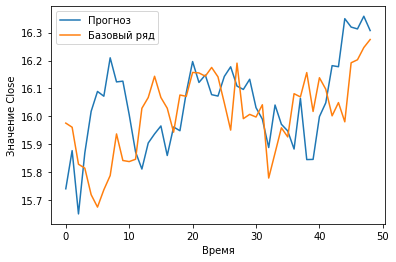

In [ ]:
#Отображаем графики
showPredict(0, 100, 5, predVal2, yValUnscaled2)

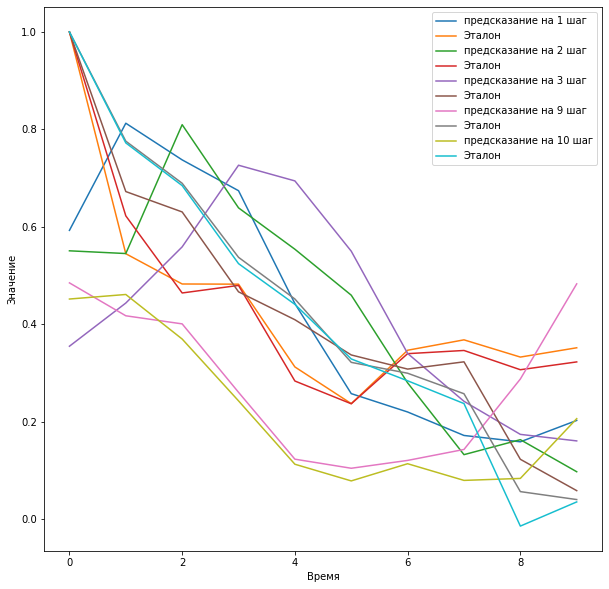

In [ ]:
#Отображаем корреляцию
plt.figure(figsize=(10,10))
showCorr([0, 1, 2, 8, 9], 10, predVal2, yValUnscaled2)

## Сложная модель. Предсказание на несколько шагов

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=8300


Epoch 1/40
33/33 [==============================] - 1s 31ms/step - loss: 0.6791 - val_loss: 10.9752
Epoch 2/40
33/33 [==============================] - 0s 9ms/step - loss: 0.4380 - val_loss: 6.3681
Epoch 3/40
33/33 [==============================] - 0s 9ms/step - loss: 0.3145 - val_loss: 5.0272
Epoch 4/40
33/33 [==============================] - 0s 8ms/step - loss: 0.2676 - val_loss: 3.8915
Epoch 5/40
33/33 [==============================] - 0s 8ms/step - loss: 0.2298 - val_loss: 3.3908
Epoch 6/40
33/33 [==============================] - 0s 8ms/step - loss: 0.2037 - val_loss: 3.2814
Epoch 7/40
33/33 [==============================] - 0s 9ms/step - loss: 0.1857 - val_loss: 2.5315
Epoch 8/40
33/33 [==============================] - 0s 9ms/step - loss: 0.1631 - val_loss: 2.2660
Epoch 9/40
33/33 [==============================] - 0s 9ms/step - loss: 0.1435 - val_loss: 1.9049
Epoch 10/40
33/33 [==============================] - 0s 9ms/step - loss: 0.1346 - val_loss: 1.7117
Epoch 11/40
33/33

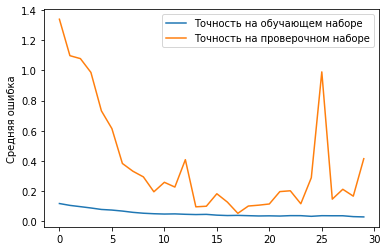

In [ ]:
dataInput = Input(shape=(xLen,6))

lstmWay = LSTM(40, return_sequences="True")(dataInput)
lstmWay = Dropout(0.3)(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmWay = LSTM(40, return_sequences="True")(lstmWay)
lstmWay = Dropout(0.3)(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(convWay)

denseWay = Dense(10, activation="linear")(dataInput)
denseWay = Dense(10, activation="linear")(denseWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
denseWay = Flatten()(denseWay)

finWay = concatenate([lstmWay, convWay, denseWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX3 = Model(dataInput, finWay)

modelX3.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelX3.fit_generator(
                    trainDataGen, 
                    epochs=40, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'][10:], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
modelX3.compile(loss="mse", optimizer=Adam(lr=1e-5))

history = modelX3.fit_generator(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

Epoch 1/50
33/33 [==============================] - 1s 24ms/step - loss: 0.0222 - val_loss: 0.1253
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0214 - val_loss: 0.1317
Epoch 3/50
33/33 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.1467
Epoch 4/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.1200
Epoch 5/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.1429
Epoch 6/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0216 - val_loss: 0.1033
Epoch 7/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0211 - val_loss: 0.1333
Epoch 8/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0208 - val_loss: 0.1242
Epoch 9/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0210 - val_loss: 0.1142
Epoch 10/50
33/33 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.1324
Epoch 11/50
33/33 

**Отображаем реультаты**

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX3
(predVal3, yValUnscaled3) = getPred(currModel, xVal[0], yVal[0], yScaler)

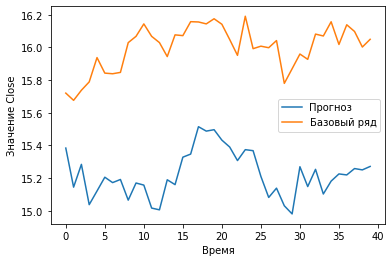

In [ ]:
#Отображаем графики
showPredict(9, 100, 0, predVal3, yValUnscaled3)

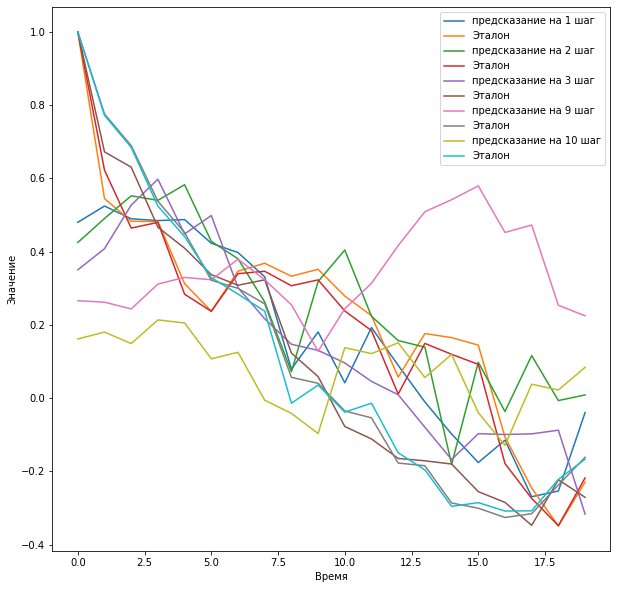

In [ ]:
#Отображаем корреляцию
plt.figure(figsize=(10,10))
showCorr([0, 1, 2, 8, 9], 20, predVal3, yValUnscaled3)

## Своя функция ошибки

*Разбор данного раздела:* https://youtu.be/7vcy8RGYOIE?t=8431


In [ ]:
### Функция ошибки
def getError(x1, x2):
  dx = (x1-x2) ** 2        #Вычислем среднеквадратичную ошибку по точкам
  dxs = np.sort(dx)[::-1]  #Сортируем ошибку в порядке убывания
  return np.mean(dxs[:10]) #Итоговая ошибка равны среднему 10 самых больших ошибок на всём отрезке

In [ ]:
#Вычисляем ошибку при прогнозе на 1 шаг
predictionStep = 0
x1 = predVal2[:,predictionStep]
x2 = yValUnscaled2[:,predictionStep]

print(getError(x1, x2))

0.11595203833937631


In [ ]:
#Отображаем ошибку при прогнозе на несколько шагов вперёд
for i in range(stepsForward):
  x1 = predVal2[:,i]
  x2 = yValUnscaled2[:,i]

  print("Шаг", i+1, "ошибка", round(getError(x1, x2),3))

Шаг 1 ошибка 0.116
Шаг 2 ошибка 0.174
Шаг 3 ошибка 0.098
Шаг 4 ошибка 0.118
Шаг 5 ошибка 0.109
Шаг 6 ошибка 0.102
Шаг 7 ошибка 0.091
Шаг 8 ошибка 0.068
Шаг 9 ошибка 0.073
Шаг 10 ошибка 0.083


In [ ]:
### Функция ошибки

def getError2(x1, x2):
  corr = []
  yLen = x1.shape[0]

  #Вычисляем корреляцию выхода сети в верным ответом
  #Смещая выход сети назад от 0 до 9 шагов
  for i in range(10):
    corr.append(correlate(x1[:yLen-i], x2[i:]))
  
  corr = np.array(corr)
  
  #Возвращаем функцию ошибки, как произведение
  #1 - корреляции без смещения (со смещением на 0)
  #2 - того, во сколько раз корреляция без смещения больше, чем средняя корреляция при смещении на 1-5 шагов
  return corr[0] * (corr[0] / np.max(corr[1:10]))

In [ ]:
#Вычисляем ошибку при прогнозе на 1 шаг
predictionStep = 0
x1 = predVal2[:,predictionStep]
x2 = yValUnscaled2[:,predictionStep]

print(getError2(x1, x2))

0.6259259337980854


In [ ]:
#Отображаем ошибку при прогнозе на несколько шагов вперёд
for i in range(stepsForward):
  x1 = predVal2[:,i]
  x2 = yValUnscaled2[:,i]

  print(round(getError2(x1, x2),4))

0.6259
0.6471
0.4004
0.1679
0.2716
0.2661
0.4108
0.3841
0.5212
0.5389


In [ ]:
#Сравнимаем две модели по новой функции ошибки
#При предсказании на несколько шагов вперёд
model1 = modelX3
model2 = modelD2

#Получаем предсказания от обеих сетей
predValM1 = yScaler.inverse_transform(model1.predict(xVal[0]))
predValM2 = yScaler.inverse_transform(model2.predict(xVal[0]))
yValUnscaled3 = yScaler.inverse_transform(yVal)

#Здаём собственную функцию ошибки
errorFunc = getError2

for i in range(stepsForward):
  x1 = predValM1[:,i]
  x2 = predValM2[:,i]
  x = yValUnscaled2[:,i]

  print("Предсказание на", i+1, "шагов: M1 =", round(errorFunc(x1, x),3), "M2 =", round(errorFunc(x2, x),3))

Предсказание на 1 шагов: M1 = 0.504 M2 = 0.626
Предсказание на 2 шагов: M1 = 0.598 M2 = 0.647
Предсказание на 3 шагов: M1 = 0.427 M2 = 0.4
Предсказание на 4 шагов: M1 = 0.217 M2 = 0.168
Предсказание на 5 шагов: M1 = 0.39 M2 = 0.272
Предсказание на 6 шагов: M1 = 0.431 M2 = 0.266
Предсказание на 7 шагов: M1 = 0.107 M2 = 0.411
Предсказание на 8 шагов: M1 = -0.465 M2 = 0.384
Предсказание на 9 шагов: M1 = 0.274 M2 = 0.521
Предсказание на 10 шагов: M1 = 0.107 M2 = 0.539
